# **Facial Expression Recognition**

In [1]:
# Libraries

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Dense
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report

## **Reading and Organiing Data**

In [2]:
# reading the data
data = pd.read_csv("../input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv")
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
cols = ["emotion","subset","pixels"]
data.columns = cols
data.columns

emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [4]:
print(data.subset.value_counts())
print(data.emotion.value_counts())

Training       28709
PrivateTest     3589
PublicTest      3589
Name: subset, dtype: int64
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [5]:
# Splitting into train test and validate

train_data = data[data["subset"]=="Training"]
val_data = data[data["subset"]=="PublicTest"]
test_data = data[data["subset"]=="PrivateTest"]

print(train_data.shape,test_data.shape,val_data.shape)

(28709, 3) (3589, 3) (3589, 3)


In [6]:
# to extract image data from pixel column

def toPixels(pixels):

    arr = np.array(pixels.split(),"float64")
    return arr

def reshapetoImage(data):

    Images = np.reshape(data["pixels"].to_list(),(data.shape[0],48,48,1))

    return Images

In [7]:
train_data["pixels"] = train_data["pixels"].apply(toPixels)
val_data["pixels"] = val_data["pixels"].apply(toPixels)
test_data["pixels"] = test_data["pixels"].apply(toPixels)

In [8]:
# images and labels

train_images = reshapetoImage(train_data)
val_images = reshapetoImage(val_data)
test_images = reshapetoImage(test_data)

train_labels = train_data["emotion"]
val_labels = val_data["emotion"]
test_labels = test_data["emotion"]

### **Visualaizing some Images**

In [9]:
def plotImages(x,y):
    plt.figure(figsize=[20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(x[i],cmap="gray")
        plt.title(emotions[y[i]])
        plt.axis("off")
    plt.show()

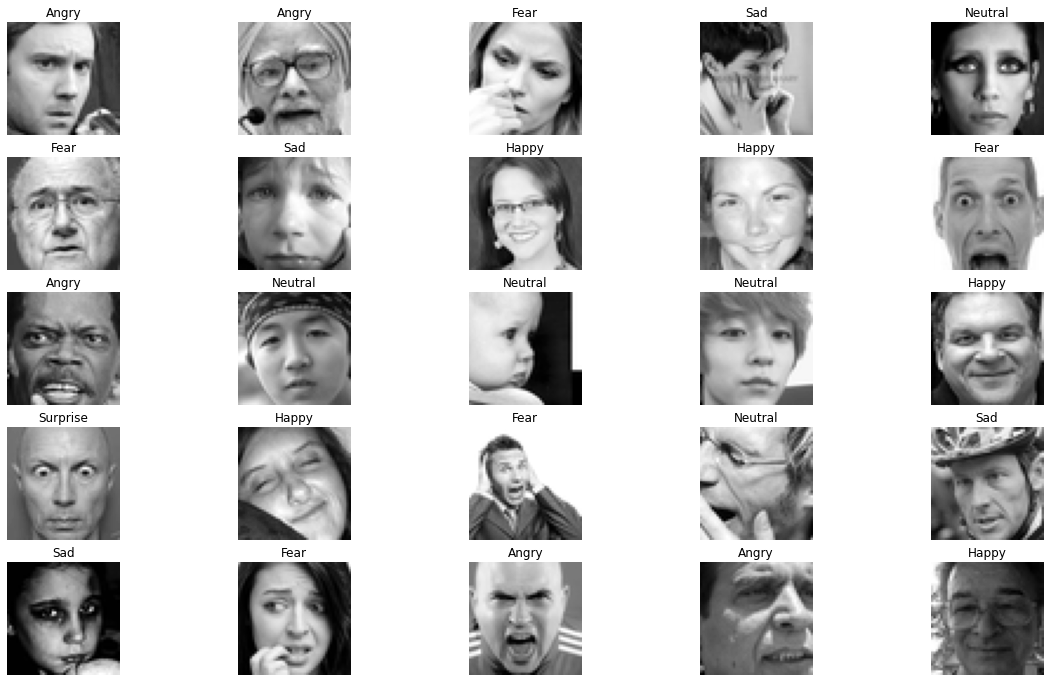

In [10]:
plotImages(train_images,train_labels)

## **Image Data Generator**

In [11]:
trainGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
                 )
valGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
               )
testGen = Imgen(rescale=1./255)

In [12]:
trainds = trainGen.flow(train_images,train_labels,
                   batch_size = 32
                   )

valds = valGen.flow(val_images,val_labels,
               batch_size = 32
               )

testds = testGen.flow(test_images,test_labels,
                      batch_size=32,
                      shuffle=False)

**One batch**

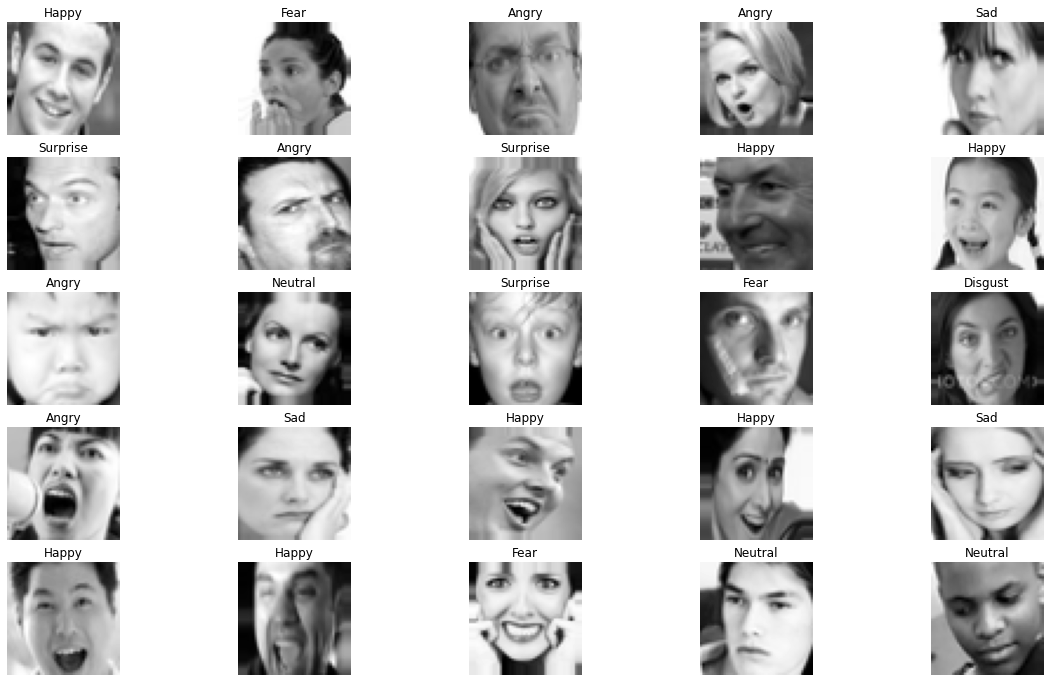

In [13]:
# one batch
x,y = next(trainds)

# see 
plotImages(x,y)

## **Model**

In [14]:
# Model
image_input = Input(shape=(48,48,1))

x = Conv2D(64,(3,3), activation="relu")(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(512,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

image_output = Dense(7,activation="softmax")(x)

model = Model(image_input,image_output)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 128)       512   

In [15]:
# Compile the model
print("Compiling the Model....")
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])
print("Model Compiled!")

Compiling the Model....
Model Compiled!


In [16]:
# Defining callbacks
my_calls = [EarlyStopping(monitor='val_accuracy',patience=5),
            ModelCheckpoint("Model_ethnicity.h5",verbose=1,save_best_only=True)]

**Train**

In [17]:
hist = model.fit(trainds, epochs=40, validation_data=valds, callbacks=my_calls)

Epoch 1/40
898/898 [==============================] - 36s 34ms/step - loss: 2.4040 - accuracy: 0.1944 - val_loss: 1.8519 - val_accuracy: 0.2756

Epoch 00001: val_loss improved from inf to 1.85187, saving model to Model_ethnicity.h5
Epoch 2/40
898/898 [==============================] - 29s 33ms/step - loss: 1.7000 - accuracy: 0.3246 - val_loss: 1.7625 - val_accuracy: 0.2678

Epoch 00002: val_loss improved from 1.85187 to 1.76253, saving model to Model_ethnicity.h5
Epoch 3/40
898/898 [==============================] - 30s 33ms/step - loss: 1.5257 - accuracy: 0.4033 - val_loss: 1.5488 - val_accuracy: 0.4062

Epoch 00003: val_loss improved from 1.76253 to 1.54877, saving model to Model_ethnicity.h5
Epoch 4/40
898/898 [==============================] - 29s 32ms/step - loss: 1.4547 - accuracy: 0.4321 - val_loss: 1.5175 - val_accuracy: 0.4252

Epoch 00004: val_loss improved from 1.54877 to 1.51748, saving model to Model_ethnicity.h5
Epoch 5/40
898/898 [==============================] - 29s 33

**Test**

In [18]:
model.evaluate(testds)

113/113 [==============================] - 3s 24ms/step - loss: 0.9962 - accuracy: 0.6317


[0.9962337613105774, 0.631652295589447]

**Graph**

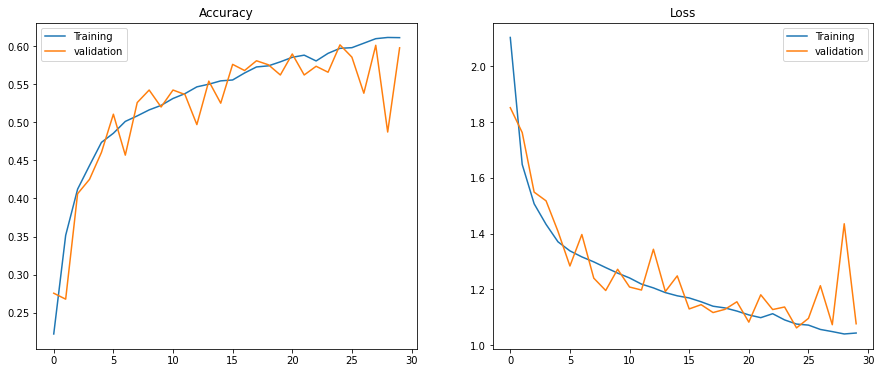

In [19]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()


## **Predictions**

In [20]:
pred = model.predict(testds)

In [21]:
pred = [np.argmax(i) for i in pred]

In [22]:
y_test = np.array(test_labels)

In [23]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       491
           1       0.70      0.38      0.49        55
           2       0.55      0.31      0.40       528
           3       0.79      0.89      0.84       879
           4       0.53      0.42      0.47       594
           5       0.71      0.75      0.73       416
           6       0.50      0.74      0.60       626

    accuracy                           0.63      3589
   macro avg       0.63      0.58      0.59      3589
weighted avg       0.63      0.63      0.62      3589



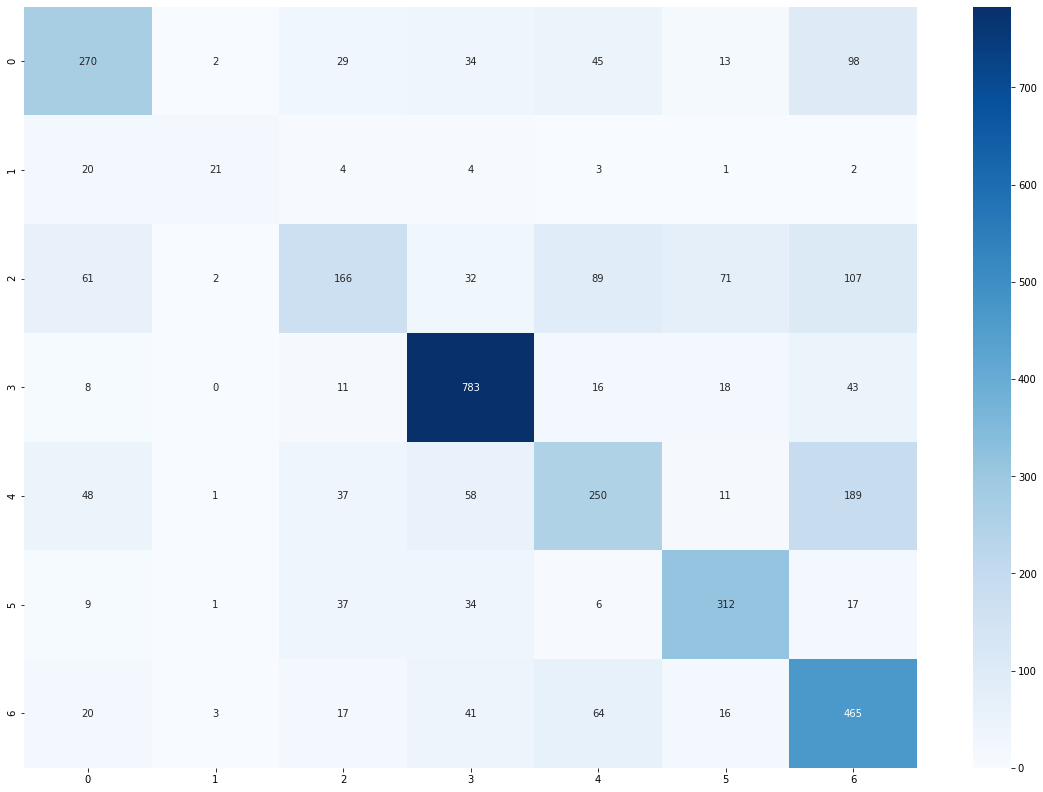

In [24]:
plt.figure(figsize=[20,14])
sns.heatmap(confusion_matrix(y_test,pred),annot = True, fmt= "d", cmap = "Blues");